C:\Users\wes.scoggin\AppData\Local\conda\conda\envs\Py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of employees in dataset: 146 

Number of Features in dataset: 21 
comprised of:
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person'] 

POIs:  18 NonPOIs: 128 

NaN / Unique Values
                      feature  nans  unique count
11              loan_advances   142             4
15              director_fees   129            17
8   restricted_stock_deferred   128            18
2           deferral_payments   107            39
16            deferred_income    97            49
17        long_term_incentive    80            66
5                       bonus    64            82
19    from_poi_to_this_person    60            86
7     shared_receipt_with_

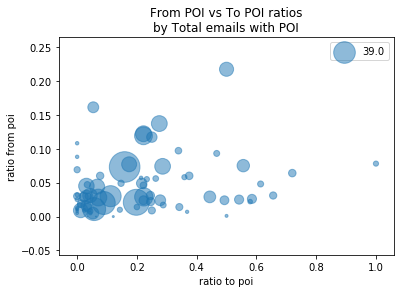


Feature Select K Best Scores:
exercised_stock_options    24.82
total_stock_value          24.18
bonus                      20.79
salary                     18.29
ratio_to_poi               16.41
long_term_incentive         9.92
restricted_stock            9.21
total_payments              8.77
shared_receipt_with_poi     8.59
expenses                    6.09
from_poi_to_this_person     5.24
other                       4.19
ratio_from_poi              3.15
dtype: float64

Final Scores for each untuned Classifier:
               Accuracy  Precision    Recall  F_Score  Num of Predictions  \
Random Forest  1.000000        1.0  1.000000     1.00                15.0   
Naive Bayes    0.866667        0.5  0.500000     0.50                15.0   
Logistic Reg   0.600000        0.5  0.166667     0.25                15.0   
Decision Tree  0.800000        0.0  0.000000     0.00                15.0   

               True positives  False positives  False negatives  \
Random Forest             2.0

C:\Users\wes.scoggin\AppData\Local\conda\conda\envs\Py27\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [2]:
# %load poi_id.py
#!/usr/bin/python

import sys
import sys
import math
sys.path.append("../tools/")
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tester import dump_classifier_and_data, test_classifier
from feature_format import featureFormat, targetFeatureSplit
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

###Examine Data
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

available_features=[]

for people, k in data_dict.iteritems():
    for key, value in k.iteritems():
        if key not in available_features:
            available_features.append(key)
print 'Number of employees in dataset:', len(data_dict),'\n'
print 'Number of Features in dataset:',len(available_features)\
,'\ncomprised of:\n', available_features,'\n'

print 'POI''s: ', sum([1 for p in data_dict if data_dict[p]['poi']==True]), \
'NonPOI''s:', sum([1 for p in data_dict if data_dict[p]['poi']==False]), '\n'

def count_unique_and_null(dictionary):
    feature_summary = []
    for feature in [f for f in available_features if f!='poi']:
        entry_unique= []
        nan_count = 0
        for entry in dictionary:
            if dictionary[entry][feature] == 'NaN':
                nan_count += 1
            elif dictionary[entry][feature] not in entry_unique and dictionary[entry][feature] !='NaN' :
                entry_unique.append(entry)
        feature_summary.append({'feature':feature
                                ,'unique count':len(entry_unique)
                                ,'nans': nan_count})
    return feature_summary

df = pd.DataFrame(count_unique_and_null(data_dict))
print 'NaN / Unique Values'
print df.sort_values(by = 'nans', ascending = False)

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = [ 'poi','salary','to_messages','total_payments','exercised_stock_options'
                 ,'bonus','restricted_stock','shared_receipt_with_poi','total_stock_value'
                 ,'expenses','from_messages','other','from_this_person_to_poi'
                 ,'long_term_incentive','from_poi_to_this_person','ratio_from_poi'
                 ,'ratio_to_poi'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
all_nan = []
for person, features in data_dict.items():
    notNaN = False
    for feature, val in features.items():
        if feature != 'poi':
            if val != 'NaN':
                notNaN = True
                break
    if not notNaN:
        all_nan.append(person)
print 'Users with all ''NaN'' data', all_nan

#Remove people identified above in code and visual inspection of employee names
for person in ['TOTAL','THE TRAVEL AGENCY IN THE PARK','LOCKHART EUGENE E']:
    data_dict.pop(person)
    

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

def computeRatio( poi_messages, all_messages ):
    if not math.isnan(float(poi_messages)) and not math.isnan(float(all_messages)):
        fraction = round(float(poi_messages)/float(all_messages),3)
    else:
        fraction =0
    return fraction

for person in data_dict:
    from_poi = data_dict[person]['from_poi_to_this_person']
    total_inbox = data_dict[person]['to_messages']
    to_poi = data_dict[person]['from_this_person_to_poi']
    total_outbox = data_dict[person]['from_messages']
    
    data_dict[person]['ratio_from_poi'] = computeRatio( from_poi, total_inbox )
    data_dict[person]['ratio_to_poi']  = computeRatio( to_poi, total_outbox )

my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

#Examine new features
print 'max to poi ratio: ', max([data_dict[p]['ratio_to_poi'] for p in data_dict])
print 'max from poi ratio: ', max([data_dict[p]['ratio_from_poi'] for p in data_dict])
print 'Person with 100% emails sent to POI',[p for p in data_dict if data_dict[p]['ratio_to_poi']==1.]

ratiosdf = pd.DataFrame(data)
ratiosdf.columns = features_list

plt.scatter(ratiosdf.ratio_to_poi, ratiosdf.ratio_from_poi
            , s=ratiosdf.from_this_person_to_poi+ratiosdf.from_poi_to_this_person
            , alpha=0.5)

plt.legend(ratiosdf.from_this_person_to_poi+ratiosdf.from_poi_to_this_person)
plt.title('From POI vs To POI ratios\nby Total emails with POI')
plt.xlabel('ratio to poi')
plt.ylabel('ratio from poi')
plt.show()

###Selecting Feautures to process with algorithms with Select K Best
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

kbest = SelectKBest(k = 13)
gaus = GaussianNB()
pipeline = Pipeline(steps = [('kbest', kbest), ('gaus', gaus)])
pipeline.fit(features, labels)

#Get Index for kbest
kbest_index = kbest.get_support(indices = True)

#add scores to dictionary with feature names as keys
scores = {}
for i in kbest_index:
    scores[features_list[i + 1]] = round(kbest.scores_[i],2)

#print ordered scores
selected_features = scores.keys()
selected_features.insert(0, 'poi')
print '\nFeature Select K Best Scores:\n', pd.Series(scores).sort_values(ascending = False)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

my_data = featureFormat(data_dict, selected_features)
labels, features = targetFeatureSplit(my_data)
#Create testing and training folds for more homogenous training and test datasets
cv = StratifiedShuffleSplit(labels, 2000, random_state = 42)
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

        #Create standar Model Scoring structure for concatenation
def modelScoring(pred, test_labels):
    accuracy = accuracy_score(pred, test_labels)
    precision = precision_score(pred, test_labels)
    recall = recall_score(pred, test_labels)
    f1 = f1_score(pred, test_labels)
    confusion = confusion_matrix(pred, test_labels)
    
    scores = {'Accuracy': accuracy
              ,'Precision': precision 
              ,'Recall': recall 
              ,'F_Score': f1
              ,'Num of Predictions':len(test_labels)
              ,'True positives': confusion[1,1]
              ,'True negatives': confusion[0,0]
              ,'False positives': confusion[0,1]
              ,'False negatives': confusion[1,0]
              }
    return scores

#Concat algorithm scores
def finalScores(scores):
    cols = ['Accuracy','Precision','Recall','F_Score','Num of Predictions','True positives','False positives','False negatives','True negatives']
    final_scores = pd.DataFrame(scores,cols).transpose()
    final_scores = final_scores.sort_values('F_Score',ascending=False)
    return final_scores

###Classifiers:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(features_train,labels_train)
pred_nb = clf_nb.predict(features_test)
nb_scores = modelScoring(pred_nb, labels_test)

#Dtree
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
clf_dt.fit(features_train,labels_train)
pred_dt = clf_dt.predict(features_test)
dt_scores = modelScoring(pred_dt, labels_test)

#Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr= LogisticRegression()
clf_lr.fit(features_train,labels_train)
pred_lr = clf_lr.predict(features_test)
lr_scores = modelScoring(pred_lr, labels_test)

#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
clf_rfc.fit(features_train, labels_train)
pred_rfc = clf_rfc.predict(features_test)
rfc_scores = modelScoring(pred_rfc, labels_test)

scores = {'Naive Bayes': nb_scores
           ,'Decision Tree': dt_scores
           ,'Logistic Reg': lr_scores
           ,'Random Forest': rfc_scores}
print '\nFinal Scores for each untuned Classifier:\n', finalScores(scores)

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

#Tuning LR Classifier
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(n_jobs = -1)
parameters = {'max_iter':range(20, 150, 10)
              ,'penalty' : ('l1', 'l2')
              ,'C': (.1,.2,.3) 
              #,.4,.5,.6,.7,.8,.9,1.) these values were also tested but .2 was selected 
             }
lr_grid = GridSearchCV(lr, parameters, n_jobs = -1)
lr_grid.fit(features_train, labels_train)

pred_lr_grid = lr_grid.predict(features_test)
logistic_reg_tuned = modelScoring(pred_lr_grid, labels_test)
print "\nSelected Tuning Parameters: ", lr_grid.best_params_

#Comparing Tuned to Untuned LR Classifier
final_scores = {'Logistic Reg Tuned': logistic_reg_tuned
           ,'Logistic Reg Untuned': lr_scores
         }
print '\nFinal tuned vs untuned Logistic Regression scores:\n', finalScores(final_scores)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
clf = lr_grid

dump_classifier_and_data(clf, my_dataset, features_list)
print '\nclf, my_dataset, features_list dumped'